In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it. 

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [3]:
path = '/kaggle/input/imagedataset/lfw'

In [4]:
transform    = transforms.Compose([transforms.ToTensor()]) 
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


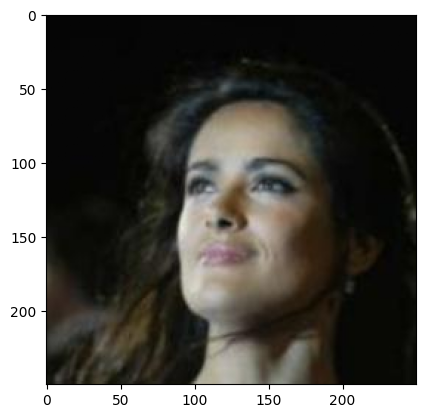

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function. 

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [83]:
class VAE(nn.Module):
    
    def __init__(self):
        super(VAE,self).__init__()
        self.num_hidden = 32
        self.encoded_images = self.encoder()
        self.decoded_images = self.decoder()
        self.mu = nn.Linear(32, self.num_hidden)
        self.log_var = nn.Linear(32, self.num_hidden)
        

    def encoder(self):
        return nn.Sequential(nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), 
                                 nn.BatchNorm2d(8),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2),  
                                 
                                 nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),  
                                 nn.BatchNorm2d(16), 
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2),  
                                 
                                 nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),  
                                 nn.BatchNorm2d(32),  
                                 nn.ReLU(True),  
                                 nn.MaxPool2d(2, stride=2) 
                                ) 
        
    def decoder(self):
        return nn.Sequential(nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(16),
                             
                             nn.ConvTranspose2d(16,8, kernel_size=3, stride=2, padding=1),
                             nn.BatchNorm2d(8),
                             
                             nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
                             nn.Tanh()
                            )
       
    def forward(self,x):
        # Pass the input through the encoder
        encoded = self.encoded_images(x)
        # Compute the mean and log variance vectors
        mu = self.mu(encoded)
        log_var = self.log_var(encoded)
        # Reparameterize the latent variable
        z = self.reparameterize(mu, log_var)
        # Pass the latent variable through the decoder
        decoded = self.decoded_images(z)
        # Return the encoded output, decoded output, mean, and log variance
        return encoded, decoded, mu, log_var
        
    
    
    def reparameterize(self, mu, log_var):
        # Compute the standard deviation from the log variance
        std = torch.exp(0.5 * log_var)
        # Generate random noise using the same shape as std
        eps = torch.randn_like(std)
        # Return the reparameterized sample
        return mu + eps * std


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly. 

In [84]:
model = VAE()

In [85]:
data = iter(dataloader)
image,target = next(data)

encoded_output = model.encoded_images(image)
print(encoded_output.shape)
decoded_output = model.decoded_images(encoded_output)

print(decoded_output.shape)

torch.Size([32, 32, 32, 32])
torch.Size([32, 3, 250, 250])


In [86]:
forward_complete = model.forward(image)


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


In [87]:
total_parameters = sum(params.numel() for params in model.parameters())
print(total_parameters)

14307


* create an optimizer for training

In [88]:
optim = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-5)

In [89]:
loss_function = nn.MSELoss()

In [90]:
if not os.path.exists('./generated'):
    os.mkdir('./generated')

def to_img(x):
    x = x.view(x.size(0), 3, 250, 250)
    return x

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [91]:
mu_f, logvar_f = output_encoder.split(output_encoder.size(1)//2,1)
print(mu_f.shape)

torch.Size([32, 8, 32, 32])


In [ ]:
for epoch in range(2):
    total_loss = 0.0
    num_batches = 0

    # Iterate over the dataset
    for real_images, _ in dataloader:
        # Forward pass
        encoded_output, decoded_output, mu, log_var = model.forward(real_images)
        
        # Compute the reconstruction loss
        reconstruction_loss = loss_function(decoded_output, real_images)

        # Compute the KL divergence loss
        kl_div_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Total loss is the sum of reconstruction loss and KL divergence loss
        loss = reconstruction_loss + kl_div_loss

        # Backward pass and optimization
        optim.zero_grad()
        loss.backward()
        optim.step()

        total_loss += loss.item()
        num_batches += 1

    # Calculate average loss for the epoch
    average_loss = total_loss / num_batches

    # Print the average loss for the epoch
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {average_loss}")

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

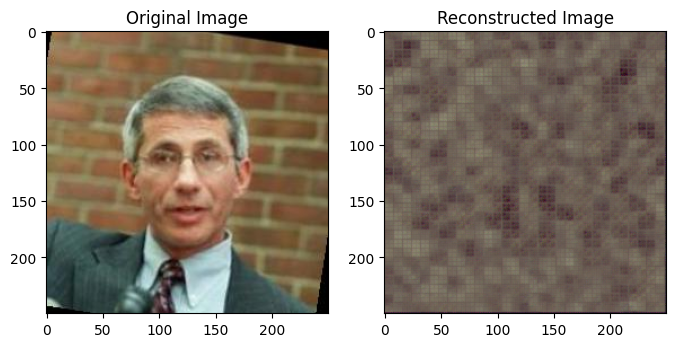

In [42]:
data = iter(dataloader)
image,target = next(data)
original_image = image[6]

# Forward pass through the model
with torch.no_grad():
    reconstructed_image = model(original_image.unsqueeze(0))  # Add an extra dimension for batch size

# Convert tensors to numpy arrays for visualization
original_image_np = original_image.permute(1, 2, 0).cpu().numpy()
reconstructed_image_np = reconstructed_image.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Plot the original and reconstructed images side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(original_image_np)
axes[0].set_title('Original Image')

axes[1].imshow(reconstructed_image_np)
axes[1].set_title('Reconstructed Image')

plt.show()